In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from torchsummary import summary


### Data Loading and Data Exploration 

Number of training samples: 11483
Number of test samples: 2871


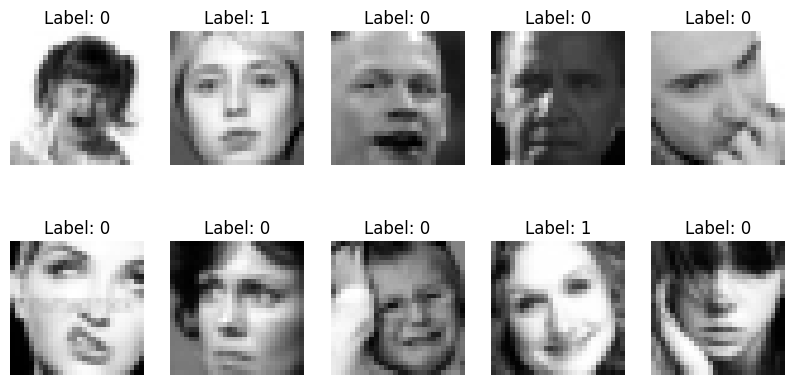

Shape of an individual training image: torch.Size([1, 28, 28])
Shape of an individual test image: torch.Size([1, 28, 28])


In [8]:


# Set the directory path
data_dir = 'fer2013BinaryData'

class SubsetDataset(Dataset):
    """A custom Dataset class that samples a subset of another dataset."""
    def __init__(self, dataset, subset_fraction=0.4):
        # Determine the indices for the subset
        total_indices = list(range(len(dataset)))
        np.random.shuffle(total_indices)
        subset_size = int(subset_fraction * len(dataset))
        self.subset_indices = total_indices[:subset_size]
        self.dataset = dataset

    def __getitem__(self, idx):
        # Fetch the dataset item using the subset index
        actual_idx = self.subset_indices[idx]
        return self.dataset[actual_idx]

    def __len__(self):
        return len(self.subset_indices)



# Define transformations for the images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale has 1 channel
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.squeeze()),  # Remove the channel dimension
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

# Load full dataset
full_train_dataset = ImageFolder(root='fer2013BinaryData/train', transform=transform)
full_test_dataset = ImageFolder(root='fer2013BinaryData/test', transform=transform)

# Wrap the full dataset with the SubsetDataset to sample only 40%
train_dataset = SubsetDataset(full_train_dataset, subset_fraction=0.4)
test_dataset = SubsetDataset(full_test_dataset, subset_fraction=0.4)

# Data loaders for the datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the shape of the datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Visualize some sample images from the training set
def plot_sample_images(loader, num_rows=2, num_cols=5):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.show()

# Plot 10 sample images
plot_sample_images(train_loader)

# Print the shape of an individual image before flattening
print(f"Shape of an individual training image: {train_dataset[0][0].shape}")
print(f"Shape of an individual test image: {test_dataset[0][0].shape}")





### Defining the Quantum Layer and Model 

In [29]:
import torch
from torch import nn
import torch.nn.functional as F
import pennylane as qml
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define the quantum device
dev = qml.device('default.qubit', wires=4)

# Define a quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(4))
    qml.templates.BasicEntanglerLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(4)]

class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        self.weights = nn.Parameter(torch.randn(3, 4))  # 3 layers, 4 qubits

    def forward(self, x):
        # Applying the quantum node to each item in the batch
        # Use torch.stack to ensure the outputs are correctly shaped as a batch tensor
        q_out = [quantum_circuit(x[i], self.weights) for i in range(x.size(0))]
        return torch.stack([torch.tensor(i, dtype=torch.float32) for i in q_out]).to(x.device)

# Define the hybrid quantum-classical class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        quantum_input = x[:, :4]  # We're encoding the first 4 features
        quantum_output = self.quantum_layer(quantum_input)
        x = torch.cat([x, quantum_output], dim=1)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification

net = Net()

summary(net, (1, 28, 28))

'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        quantum_input = x[:, :4]  # We're encoding the first 4 features
        quantum_output = self.quantum_layer(quantum_input)
        x = torch.cat([x, quantum_output], dim=1)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification
'''



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 64]           8,256
      QuantumLayer-3                    [-1, 4]               0
            Linear-4                    [-1, 1]              69
Total params: 108,805
Trainable params: 108,805
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


### Training the model 

Starting training...
Epoch 1/20 - Loss: 0.6780617154076238
Epoch 2/20 - Loss: 0.6627473251733276
Epoch 3/20 - Loss: 0.6565767362257232
Epoch 4/20 - Loss: 0.6474526879847216
Epoch 5/20 - Loss: 0.6466549205746823
Epoch 6/20 - Loss: 0.6420581976683359
Epoch 7/20 - Loss: 0.636997433592018
Epoch 8/20 - Loss: 0.6359370264502289
Epoch 9/20 - Loss: 0.6317023105275996
Epoch 10/20 - Loss: 0.627008558315819
Epoch 11/20 - Loss: 0.6245413503939062
Epoch 12/20 - Loss: 0.6236352581831738
Epoch 13/20 - Loss: 0.6209466889874184
Epoch 14/20 - Loss: 0.6165964462298869
Epoch 15/20 - Loss: 0.6171194399631788
Epoch 16/20 - Loss: 0.6138509822423079
Epoch 17/20 - Loss: 0.6119727574517135
Epoch 18/20 - Loss: 0.6095335070137194
Epoch 19/20 - Loss: 0.6068942301950747
Epoch 20/20 - Loss: 0.6054844642914106
Training completed in 1553.115 seconds.


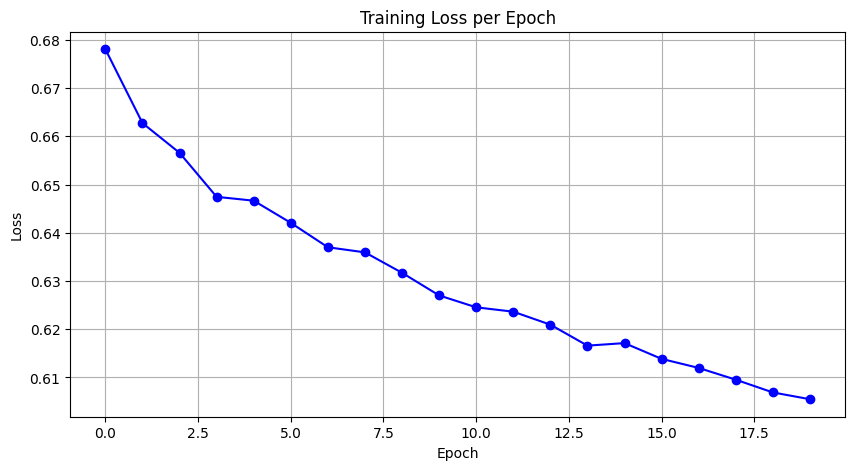

Accuracy: 0.6276558690351793
Precision: 0.720614828209765
Recall: 0.5118818240205524
F1 Score: 0.5985730379271498


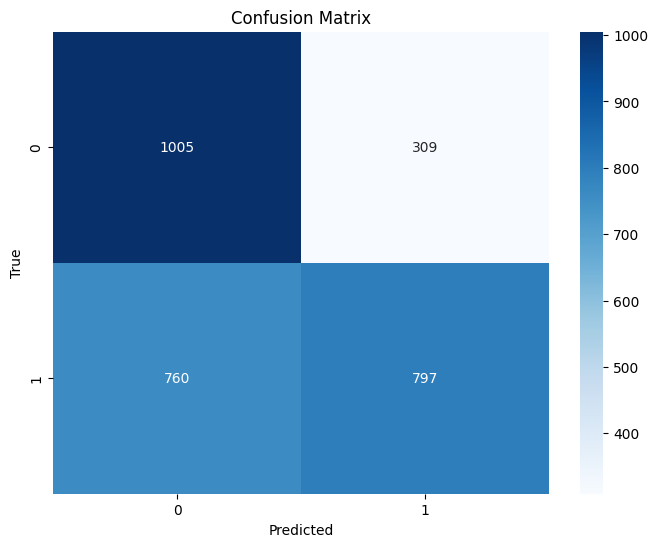

In [26]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# To keep track of the loss values
losses = []

# Training the network
epochs = 20
print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()  # Reshape labels and convert to float
        
        # Flatten images into a 784 long vector (28x28)
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss/len(train_loader)}")
        losses.append(running_loss / len(train_loader))

end_time = time.time()
print(f"Training completed in {end_time - start_time:.3f} seconds.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation
net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()  # Reshape labels and convert to float
        images = images.view(images.shape[0], -1)
        outputs = net(images)
        preds = torch.round(outputs)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Starting training...
Epoch 1/20 - Loss: 0.6780617154076238
Epoch 2/20 - Loss: 0.6627473251733276
Epoch 3/20 - Loss: 0.6565767362257232
Epoch 4/20 - Loss: 0.6474526879847216
Epoch 5/20 - Loss: 0.6466549205746823
Epoch 6/20 - Loss: 0.6420581976683359
Epoch 7/20 - Loss: 0.636997433592018
Epoch 8/20 - Loss: 0.6359370264502289
Epoch 9/20 - Loss: 0.6317023105275996
Epoch 10/20 - Loss: 0.627008558315819
Epoch 11/20 - Loss: 0.6245413503939062
Epoch 12/20 - Loss: 0.6236352581831738
Epoch 13/20 - Loss: 0.6209466889874184
Epoch 14/20 - Loss: 0.6165964462298869
Epoch 15/20 - Loss: 0.6171194399631788
Epoch 16/20 - Loss: 0.6138509822423079
Epoch 17/20 - Loss: 0.6119727574517135
Epoch 18/20 - Loss: 0.6095335070137194
Epoch 19/20 - Loss: 0.6068942301950747
Epoch 20/20 - Loss: 0.6054844642914106
Training completed in 1553.115 seconds.


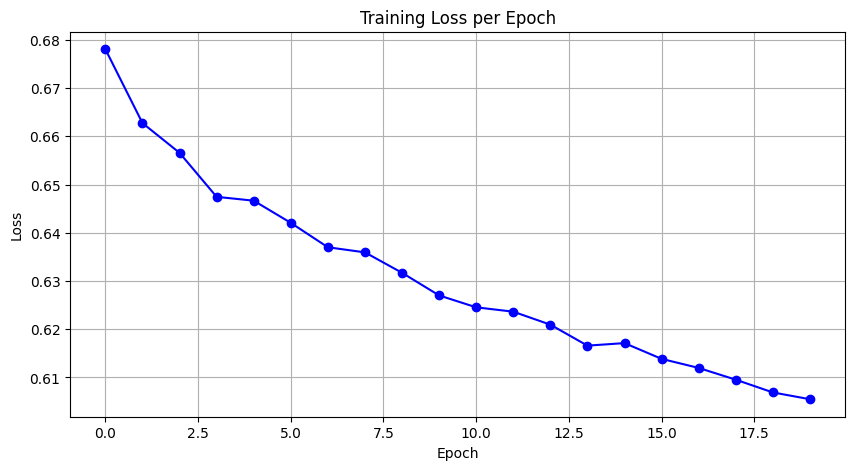

Accuracy: 0.6276558690351793
Precision: 0.720614828209765
Recall: 0.5118818240205524
F1 Score: 0.5985730379271498


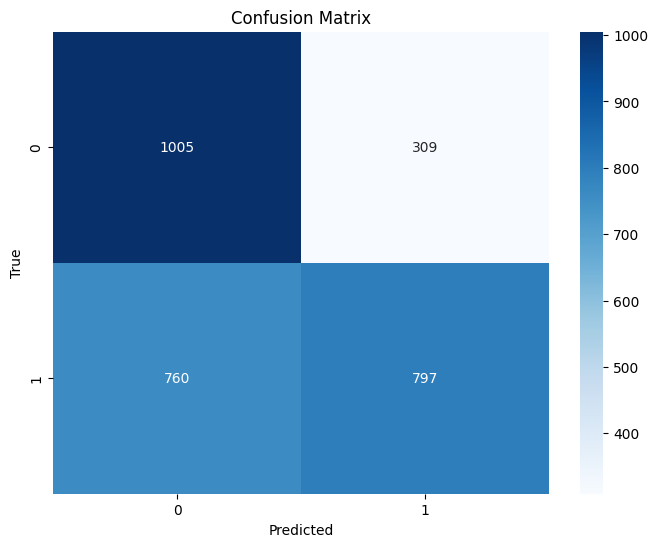

In [26]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# To keep track of the loss values
losses = []

# Training the network
epochs = 20
print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()  # Reshape labels and convert to float
        
        # Flatten images into a 784 long vector (28x28)
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss/len(train_loader)}")
        losses.append(running_loss / len(train_loader))

end_time = time.time()
print(f"Training completed in {end_time - start_time:.3f} seconds.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation
net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()  # Reshape labels and convert to float
        images = images.view(images.shape[0], -1)
        outputs = net(images)
        preds = torch.round(outputs)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#The output below here is for the architecture without drop out layers

### Evaluation

Accuracy: 0.6144200626959248
Precision: 0.7094972067039106
Recall: 0.48940269749518306
F1 Score: 0.5792474344355758


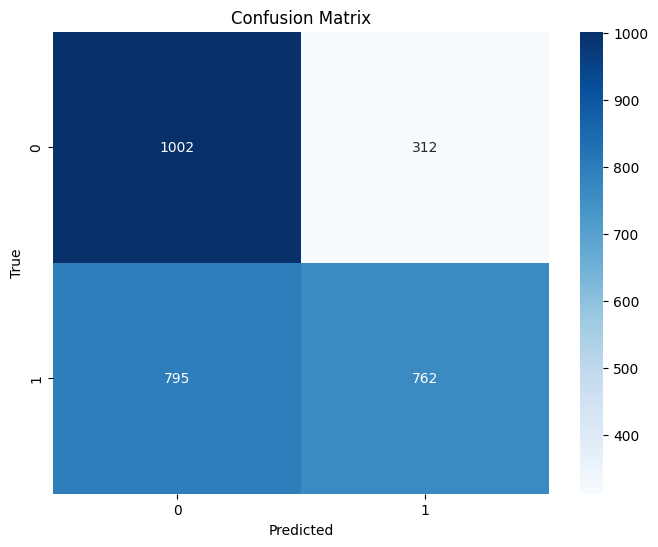

In [18]:


# Evaluation
net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)
        outputs = net(images)
        preds = torch.round(outputs)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## The previous architecture only selected the first 4 features prior the quantum layer. In this part of the code, we Apply PCA to derive more important features: 

Fitting PCA on the Intermediate Output:

We first pass some training data through the Net class (up to the second fully connected layer) and fit PCA on this 64-dimensional output.
Creating the HybridNet Class:

The HybridNet class integrates the PCA transformation into the forward pass before the quantum layer.
Training Loop:

The training loop uses the HybridNet class for training and evaluation.




In [32]:
from sklearn.decomposition import PCA
import torch

# Define the hybrid quantum-classical class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

# Instantiate the network
net = Net().to(device)

# Fit PCA on the output of the second fully connected layer
net.eval()
with torch.no_grad():
    outputs = []
    for images, _ in train_loader:
        images = images.to(device)
        images = images.view(images.shape[0], -1)
        outputs.append(net(images).cpu().numpy())
outputs = np.concatenate(outputs)
pca = PCA(n_components=4)
pca.fit(outputs)

# Define the final hybrid network with PCA transformation
class HybridNet(nn.Module):
    def __init__(self, pca):
        super(HybridNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification
        self.pca = pca

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        # Apply PCA to get the most important 4 features
        quantum_input = torch.tensor(self.pca.transform(x.detach().cpu().numpy()), dtype=torch.float32).to(x.device)
        quantum_output = self.quantum_layer(quantum_input)
        x = torch.cat([x, quantum_output], dim=1)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification

# Instantiate the final network
hybrid_net = HybridNet(pca).to(device)

summary(hybrid_net,(1, 28, 28))
'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        quantum_input = x[:, :4]  # We're encoding the first 4 features
        quantum_output = self.quantum_layer(quantum_input)
        x = torch.cat([x, quantum_output], dim=1)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification
'''

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
           Dropout-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
           Dropout-4                   [-1, 64]               0
      QuantumLayer-5                    [-1, 4]               0
            Linear-6                    [-1, 1]              69
Total params: 108,805
Trainable params: 108,805
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


"\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.fc1 = nn.Linear(28*28, 128)\n        self.dropout1 = nn.Dropout(0.5)\n        self.fc2 = nn.Linear(128, 64)\n        self.dropout2 = nn.Dropout(0.5)\n        self.quantum_layer = QuantumLayer()\n        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification\n\n    def forward(self, x):\n        x = x.view(-1, 28*28)\n        x = F.relu(self.fc1(x))\n        x = self.dropout1(x)\n        x = F.relu(self.fc2(x))\n        x = self.dropout1(x)\n        quantum_input = x[:, :4]  # We're encoding the first 4 features\n        quantum_output = self.quantum_layer(quantum_input)\n        x = torch.cat([x, quantum_output], dim=1)\n        x = self.fc3(x)\n        return torch.sigmoid(x)  # Use sigmoid for binary classification\n"

#### Now we repeat the training step and evaluation step  

In [ ]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(hybrid_net.parameters(), lr=0.001)

# To keep track of the loss values
losses = []

# Training the network
epochs = 30
print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()  # Reshape labels to [batch_size, 1]
        
        # Flatten images into a 784 long vector (28x28)
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = hybrid_net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss/len(train_loader)}")
        losses.append(running_loss / len(train_loader))

end_time = time.time()
print(f"Training completed in {end_time - start_time:.3f} seconds.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation
hybrid_net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()  # Reshape labels to [batch_size, 1]
        images = images.view(images.shape[0], -1)
        outputs = hybrid_net(images)
        preds = torch.round(outputs)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=1)
recall = recall_score(all_labels, all_preds, zero_division=1)
f1 = f1_score(all_labels, all_preds, zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Starting training...


Starting training...
Epoch 1/20 - Loss: 0.6205794902565087
Epoch 2/20 - Loss: 0.6196649441479972
Epoch 3/20 - Loss: 0.6172729418470335
Epoch 4/20 - Loss: 0.6169498234904244
Epoch 5/20 - Loss: 0.6129059047752105
Epoch 6/20 - Loss: 0.610730891523255
Epoch 7/20 - Loss: 0.6071416577090792
Epoch 8/20 - Loss: 0.6111748758132743
Epoch 9/20 - Loss: 0.6046352612274934
Epoch 10/20 - Loss: 0.6039544898487399
Epoch 11/20 - Loss: 0.6038228909285288
Epoch 12/20 - Loss: 0.5985728487330891
Epoch 13/20 - Loss: 0.6011070880551193
Epoch 14/20 - Loss: 0.6012374972898648
Epoch 15/20 - Loss: 0.5940755080213785
Epoch 16/20 - Loss: 0.596404901703088
Epoch 17/20 - Loss: 0.5925513733396292
Epoch 18/20 - Loss: 0.5910990447387058
Epoch 19/20 - Loss: 0.5916139170485951
Epoch 20/20 - Loss: 0.5922527499185631
Training completed in 1418.427 seconds.


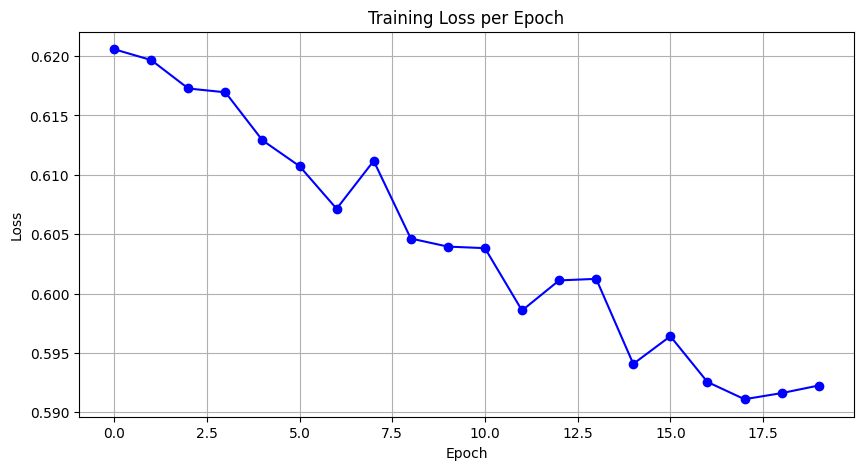

Accuracy: 0.6290491118077325
Precision: 0.7161687170474517
Recall: 0.5234425176621709
F1 Score: 0.6048237476808905


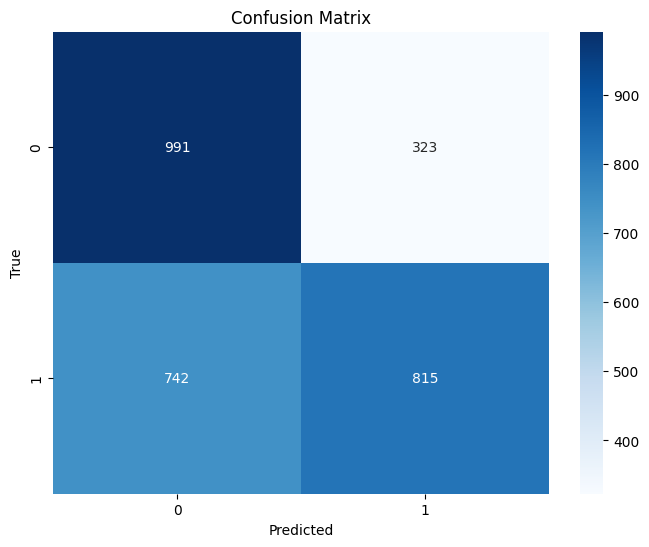

In [24]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(hybrid_net.parameters(), lr=0.001)

# To keep track of the loss values
losses = []

# Training the network
epochs = 20
print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()  # Reshape labels to [batch_size, 1]
        
        # Flatten images into a 784 long vector (28x28)
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = hybrid_net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss/len(train_loader)}")
        losses.append(running_loss / len(train_loader))

end_time = time.time()
print(f"Training completed in {end_time - start_time:.3f} seconds.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation
hybrid_net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()  # Reshape labels to [batch_size, 1]
        images = images.view(images.shape[0], -1)
        outputs = hybrid_net(images)
        preds = torch.round(outputs)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=1)
recall = recall_score(all_labels, all_preds, zero_division=1)
f1 = f1_score(all_labels, all_preds, zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# FER-2013 BINARY 
1. Regular NN structure
2. Hybrid structure with pooling
3. Hybrid with PCA
4. Hybrid with Angle Encoding
5. Hybrid with MPS

### Data Loading and Data Exploration 